# Using lifelines to fit KM curves

References:<br>
  - https://lifelines.readthedocs.io/en/latest/fitters/univariate/KaplanMeierFitter.html  # noqa

In [12]:
from lifelines import KaplanMeierFitter
from lifelines.datasets import load_waltons
import matplotlib.pyplot as plt

In [13]:
from IPython.core.interactiveshell import InteractiveShell  # noqa

In [14]:
InteractiveShell.ast_node_interactivity = "all"

## Example 1

In [15]:
waltons = load_waltons()
waltons.columns = ["time", "event", "group"]
waltons.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
time,163,NaN,NaN,NaN,49.6135,17.078,6,41,56,61,75
event,163,NaN,NaN,NaN,0.957055,0.203357,0,1,1,1,1
group,163,2,control,129,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<lifelines.KaplanMeierFitter:"waltons_data", fitted with 163 total observations, 7 right-censored observations>

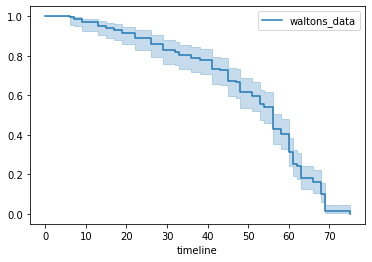

In [16]:
kmf = KaplanMeierFitter(label="waltons_data")
kmf.fit(waltons["time"], waltons["event"])
kmf.plot_survival_function()
plt.show()

## Example 2